### Learning ```torch.nn``` Module of PyTorch

<br>
<br>

**Deep Neural Networks:** 
                
                Mathematical entities capable of representing complicated functions through a composition of 
                simpler functions. The term neural network is obviously suggestive of a link to the way our brain works.
                
The basic building block of the Network is a **neuron**. At its core it just does a linear transformation of input by multiplying *weight* by *input* and adding *bias*

Mathematically: $A = f(w*x + b)$ where $A$ is activation of that neuron

*Layer*: A **layer** in a NN is a collection of neuron. There are 3 types of layer Input, Hidden and Output.

#### Understanding error function in NN

    Neural networks do not have that same property of a convex error surface, even when using the same error-squared 
    loss function! There’s no single right answer for each parameter we’re attempting to approximate. Instead, we are
    trying to get all of the parameters, when acting in concert, to produce a useful output. Since that useful output 
    is only going to approximate the truth, there will be some level of imperfection.
    

**Activation Functions** 
        
        Activation functions are mathematical equations that determine the output of a neural network. The function is 
        attached to each neuron in the network, and determines whether it should be activated (“fired”) or not, based
        on whether each neuron's input is relevant for the model's prediction.
        
The activation function plays two important roles:
- In the inner parts of the model, it allows the output function to have different slopes at different values—something 
  a linear function by definition cannot do. By trickily composing these differently sloped parts for many outputs, 
  neural networks can approximate arbitrary functions.
- At the last layer of the network, it has the role of concentrating the outputs of the preceding linear operation
  into a given range.
  
**Types of Activation function**

                     Tanh                                    Hardtanh                                    Sigmoid
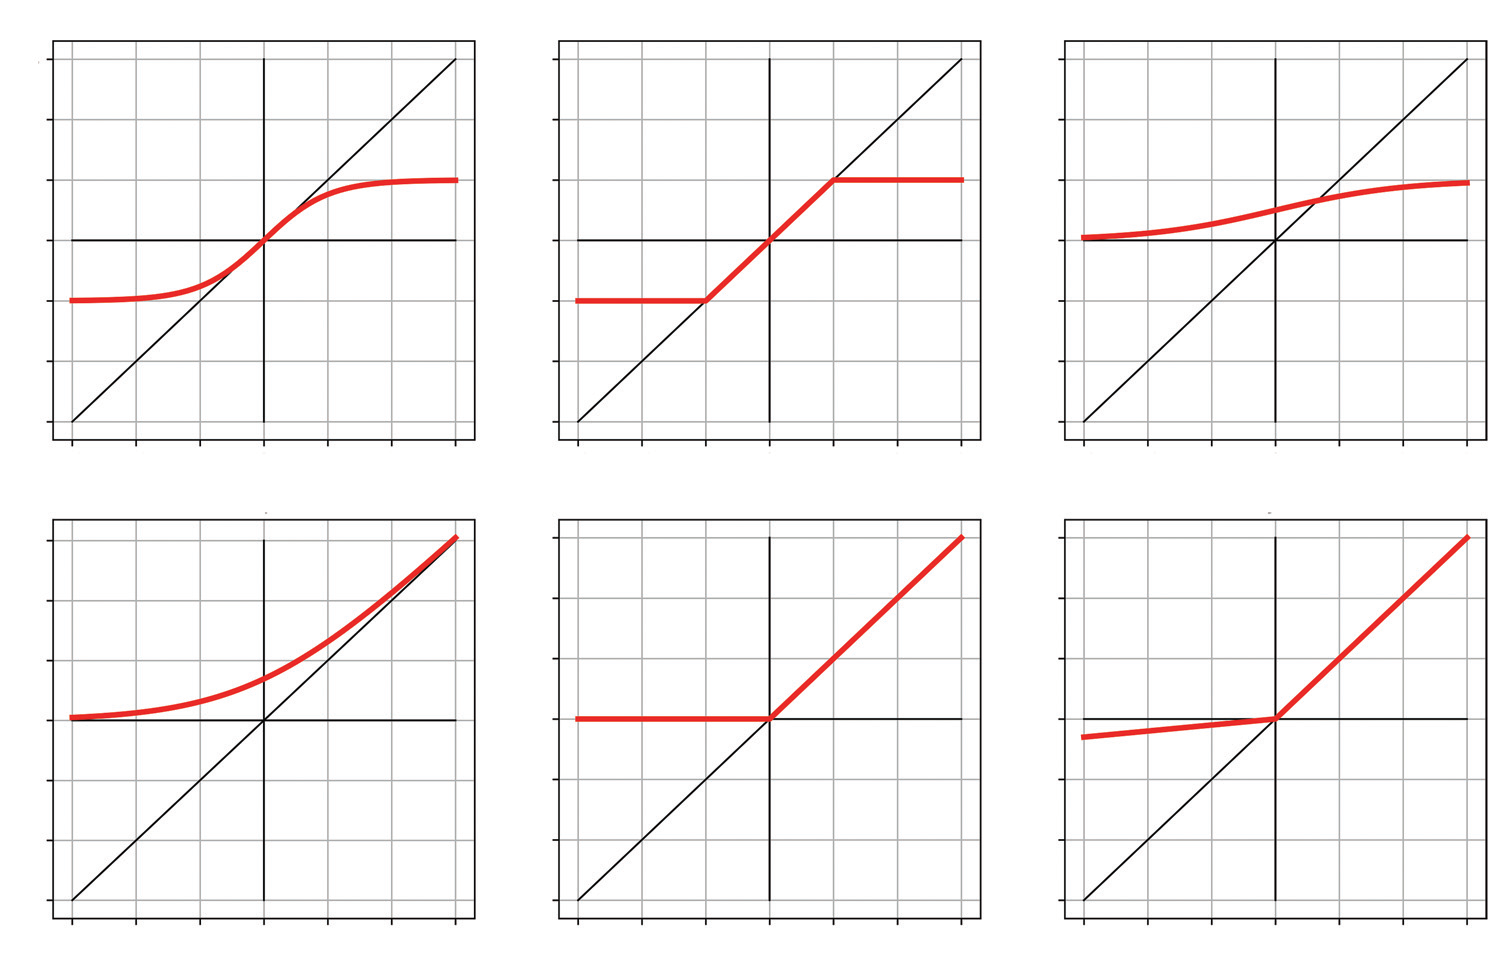
    
                   Softplus                                    ReLU                                     leakyReLU

#### Learning in Neural Network

    A successfully trained network, through the values of its weights and biases, will capture the inherent structure of 
    the data in the form of meaningful numerical representations that work correctly for previously unseen data.

**A Deeper Realization**

    Deep neural networks give us the ability to approximate highly nonlinear phenomena without having an explicit model 
    for them. Instead, starting from a generic, untrained model, we specialize it on a task by providing it with a set 
    of inputs and outputs and a loss function from which to backpropagate. Specializing a generic model to a task using 
    examples is what we refer to as learning, because the model wasn’t built with that specific task in mind—no rules
    describing how that task worked were encoded in the model.

In [ ]:
import torch
import csv

import torch.nn as nn
import numpy as np

from torch.nn import Linear, MSELoss, L1Loss
from torch import optim

#### PyTorch ```nn``` Module
    
    PyTorch has a whole submodule dedicated to neural networks, called torch.nn. It contains the building blocks needed to 
    create all sorts of neural network architectures. Those building blocks are called modules in PyTorch parlance 
    (such building blocks are often referred to as layers in other frameworks).
    
A module can have one or more ***Parameter*** instances as attributes, which are tensors whose values are optimized during the
training process (think **w** and **b** in our linear model). A module can also have one or more submodules (subclasses of ***nn.Module***) as attributes, and it will be able to track their parameters as well. 

**Note:** 

    The submodules must be top-level attributes, not buried inside list or dict instances! Otherwise, the optimizer will 
    not be able to locate the submodules (and, hence, their parameters). For situations where your model requires a list
    or dict of submodules, PyTorch provides "nn.ModuleList" and "nn.ModuleDict".

In [ ]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# Changing the size to (11,1)
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:

            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f}, Validation loss {loss_val.item():.4f}")

#### Constructor of Linear.nn
```python
    Linear(inp_feature, out_feature, bias)
```
Three Arguments: 
        
        The number of input features, the number of output features, and whether the linear model includes a bias or not 
        (defaulting to True, here):

In [ ]:
linear_model = Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c
)

In [ ]:
print(linear_model.weight)
print(linear_model.bias)

### Defining Neural Network using PyTorch

In [ ]:
seq_model = nn.Sequential(
    nn.Linear(1,13),
    nn.Tanh(),
    nn.Linear(13,1)   
)
seq_model

In [ ]:
[param.shape for param in seq_model.parameters()]

#### Naming the module

In [ ]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)


In [ ]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_layer', nn.Linear(1,13)),
    ('activation_layer', nn.Tanh()),
    ('output_layer', nn.Linear(13,1))
]))

In [ ]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

In [ ]:
seq_model.output_layer.bias

In [ ]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c
)
print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_layer.weight.grad)

In [ ]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=70)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

### Exercise

**Exercise one** 
        
    Experiment with the number of hidden neurons in our simple neural network
    model, as well as the learning rate.
        a. What changes result in more linear output from the model?
            1. Chaning the activation is giving a Linear output

        b. Can you get the model to obviously overfit the data?
            1. Increasing the number of epoch will overfit the model
            2. Making the Network more complex by adding either new neuron or new hidden layers

In [ ]:
seq_model_relu = nn.Sequential(
    nn.Linear(1,13),
    nn.ReLU(),
    nn.Linear(13,1),
)
seq_model_relu

In [ ]:
optimizer = optim.Adam(seq_model_relu.parameters(), lr=1e-2)
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=seq_model_relu,
    loss_fn=nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c
)

In [ ]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=70)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model_relu(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model_relu(0.1 * t_u).detach().numpy(), 'kx')

**Exercise Two**

    The third-hardest problem in physics is finding a proper wine to celebrate discoveries.
    Load the wine data from chapter 4, and create a new model with the appropriate number
    of input parameters.
    
    a. How long does it take to train compared to the temperature data we have
    been using?
        A Little more than the previous example as there were 3919 sample examples and 11 features.
        Since I also added one more hidden layer the time was increased due to backpropogation.
        
    b. Can you explain what factors contribute to the training times?
        Features, Hidden Layers, and Number of training examples
    
    c. Can you get the loss to decrease while training on this dataset?
        Not really.
    
    d. How would you go about graphing this dataset?
    

In [ ]:
wine_path = "F:/Study/Dataset/PyTorch/dlwpt-code-master/data/p1ch4/tabular-wine/winequality-white.csv"

wine_data = np.loadtxt(wine_path, delimiter=';', skiprows=1, dtype=np.float32)

col_list = next(csv.reader(open(wine_path), delimiter=';'))

wine_tensor = torch.from_numpy(wine_data)

# Seperate data and target
data = wine_tensor[:,:-1]
target = wine_tensor[:, -1].float()
target = target.unsqueeze(1)

In [ ]:
n_samples = data.shape[0]
n_idx = int(0.2 * n_samples)

shuffled_index = torch.randperm(n_samples)

train_indices = shuffled_index[:-n_idx]
valid_indices = shuffled_index[-n_idx:]

X_train = data[train_indices]
y_train = target[train_indices]

X_valid = data[valid_indices]
y_valid = target[valid_indices]

In [ ]:
print(X_train.shape)
X_valid.shape

In [ ]:
wine_model = nn.Sequential(
    nn.Linear(11, 12),
    nn.ReLU(),
    nn.Linear(12,9),
    nn.ReLU(),
    nn.Linear(9,1)
)
wine_model

In [ ]:
optimizer = optim.Adam(wine_model.parameters(), lr=1e-2)

In [ ]:
# Normalizing data
def normalize_data(train_data, target_data,dim=0):
    mean = train_data.mean(dim=0)
    std = train_data.std(dim=0)

    data_norm = (target_data - mean)/std
    print(data_norm.shape, target_data.shape)
    return data_norm

In [ ]:
X_train_norm = normalize_data(X_train, X_train)
X_valid_norm = normalize_data(X_train, X_valid)

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f}, Validation loss {loss_val.item():.4f}")

# training_loop(
#     n_epochs=3000,
#     optimizer=optimizer,
#     model=wine_model,
#     loss_fn=nn.L1Loss(),
#     t_u_train = X_train_norm,
#     t_u_val = X_valid_norm,
#     t_c_train = y_train,
#     t_c_val = y_valid
# )
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=wine_model,
    loss_fn=nn.L1Loss(),
    t_u_train = X_train,
    t_u_val = X_valid,
    t_c_train = y_train,
    t_c_val = y_valid
)